In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

In [133]:
#export
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cname = cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"
def test_eq(a, b):
    test(a, b, operator.eq, '==')

In [7]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/default/.fastai/data/mnist.pkl.gz')

In [8]:
with gzip.open(path, 'rb') as f:
    ((x_tr, y_tr), (x_vl, y_vl), _) = pickle.load(f, encoding='latin-1')

In [9]:
x_tr, y_tr, x_vl, y_vl = map(tensor, (x_tr, y_tr, x_vl, y_vl))

In [10]:
x = x_tr[0]

In [11]:
mpl.rcParams['image.cmap'] = 'gray'

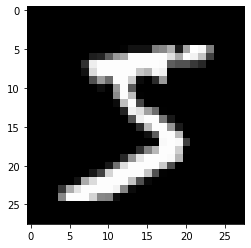

In [12]:
plt.imshow (x.view(28,28))

In [25]:
ws = torch.randn(784, 10)
b = torch.zeros(10)
xs = x_tr[:5]
ws.shape,b.shape, xs.shape

(torch.Size([784, 10]), torch.Size([10]), torch.Size([5, 784]))

In [29]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k]*b[k,j]
    return c

In [34]:
c1 = matmul(xs, ws)

In [35]:
c2 = xs@ws

In [43]:
xs[0].shape, ws[:,0].shape

(torch.Size([784]), torch.Size([10]))

In [38]:
c1.shape, c2.shape

(torch.Size([5, 10]), torch.Size([5, 10]))

In [49]:
%time c = matmul(xs, ws)

CPU times: user 651 ms, sys: 0 ns, total: 651 ms
Wall time: 651 ms


In [50]:
def matmul1(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i][j] = (a[i,:]*b[:,j]).sum()
    return c

In [51]:
%time c = matmul1(xs, ws)

CPU times: user 2.16 ms, sys: 181 µs, total: 2.34 ms
Wall time: 2.35 ms


[1,2,3] [1,2,3,4,5] <br />
[4,5,6] [1,2,3,4,5] <br />
[7,8,9] [1,2,3,4,5] <br />

[1,2,3] => [[1],[2],[3]] => broadcast along column <br />
[1,1,1,1,1] <br />
[2,2,2,2,2] <br /> 
[3,3,3,3,3] <br />
mult to <br />
[1,2,3,4,5] <br />
[1,2,3,4,5] <br />
[1,2,3,4,5] <br />

sum along columns <br />
Rule of thumb to find axis:  <br />
take out the shape of matrix <br />
say shape (5,5) <br />
across rows (along columns) is axis 0 <br />
across columns (along rows) is axis 1 <br />
Think in terms of across, not along <br />

In [60]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]])
m.T.sum(-1)

tensor([12., 15., 18.])

In [84]:
m[...].shape, m.T.shape

(torch.Size([3, 3]), torch.Size([3, 3]))

In [87]:
m[0,:,None],m

(tensor([[1.],
         [2.],
         [3.]]),
 tensor([[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]))

In [113]:
def matmul2(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i,:,None]*b).sum(0)
    return c

In [114]:
%time c = matmul2(xs, ws)

CPU times: user 626 µs, sys: 45 µs, total: 671 µs
Wall time: 409 µs


In [115]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [128]:
def matmul3(a, b): return torch.einsum('ij,jk->ik', xs, ws)

In [129]:
test_near(matmul(xs, ws), matmul1(xs, ws))
test_near(matmul(xs, ws), matmul2(xs, ws))
test_near(matmul3(xs,ws), matmul2(xs,ws))

In [132]:
%time t2 = matmul2(xs,ws)
%time t3 = matmul3(xs, ws)
%time t4 = xs.matmul(ws)
%time t5 = xs@ws

CPU times: user 796 µs, sys: 47 µs, total: 843 µs
Wall time: 553 µs
CPU times: user 540 µs, sys: 32 µs, total: 572 µs
Wall time: 385 µs
CPU times: user 340 µs, sys: 20 µs, total: 360 µs
Wall time: 271 µs
CPU times: user 371 µs, sys: 0 ns, total: 371 µs
Wall time: 279 µs


In [135]:
!python3 notebook2script.py matmul.ipynb --destName=tests

Converted matmul.ipynb to exp/tests.py
